---
tags:
- pytorch

include:
- math
---

# 搭建模型

在pytorch搭建各种各样的神经网络是非常方便的，我感觉这也是pytorch在科研圈大热的原因之一。

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(0)

## 模型发展史

深度学习发展至今，模型结构已经演化地错综复杂。网上找了一张神经网络发展的脉络图：

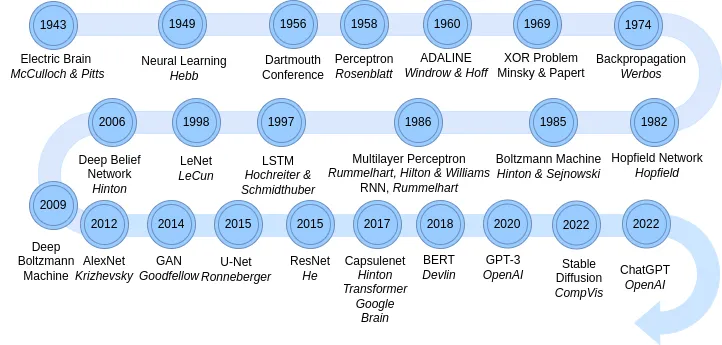

> 图源：[A Brief History of Neural Nets](https://pub.towardsai.net/a-brief-history-of-neural-nets-472107bc2c9c)

这张基本囊括了今天要介绍的模型。

## 感知器

1958由Rosenblatt提出的[感知器](https://psycnet.apa.org/record/1959-09865-001)（Perceptron）应该是最早的ANN（artificial neural network）了。

它本质上就是一个二维平面的线性分类器：

$$
y = f(x) = \frac{w^Tx+\epsilon}{|w^Tx+\epsilon|}
$$

根据$w^Tx$的符号来输出分类结果。

In [2]:
class Perceptron(nn.Module):
    """
    Perceptron.

    Rosenblatt, F. (1958). The perceptron: a probabilistic model for information storage and organization in the brain. Psychological review, 65(6), 386.
    """

    def __init__(self, input_size, output_size=1, episilon=1e-6):
        super(Perceptron, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.episolon = episilon

    def forward(self, x):
        t = self.linear(x)
        return (t + self.episolon) / torch.abs(t + self.episolon)

In [3]:
x = torch.randn(3)
p = Perceptron(3)
p(x)

tensor([1.], grad_fn=<DivBackward0>)

## 多层感知器

感知器有一个很大的问题：他是线性的，无法处理非线性问题，1969年发表的《Perceptrons: An Introduction to Computational Geometry》一书中就提出了[XOR函数的拟合问题](https://en.wikipedia.org/wiki/Perceptrons_(book))。

自然地，人们就开始扩展感知器，得到了多层感知器（MLP）。不过这种模型比较复杂，难以训练。直到1986年，Hinton他们发表了文章，使用反向传播算法求解MLP，MLP才真正可用。

> 当然，反向传播算法并非Hinton他们发明的，而是1974年[Pail Werbos](https://en.wikipedia.org/wiki/Paul_Werbos)发明。

这时候MLP的结构已经很现代化了：


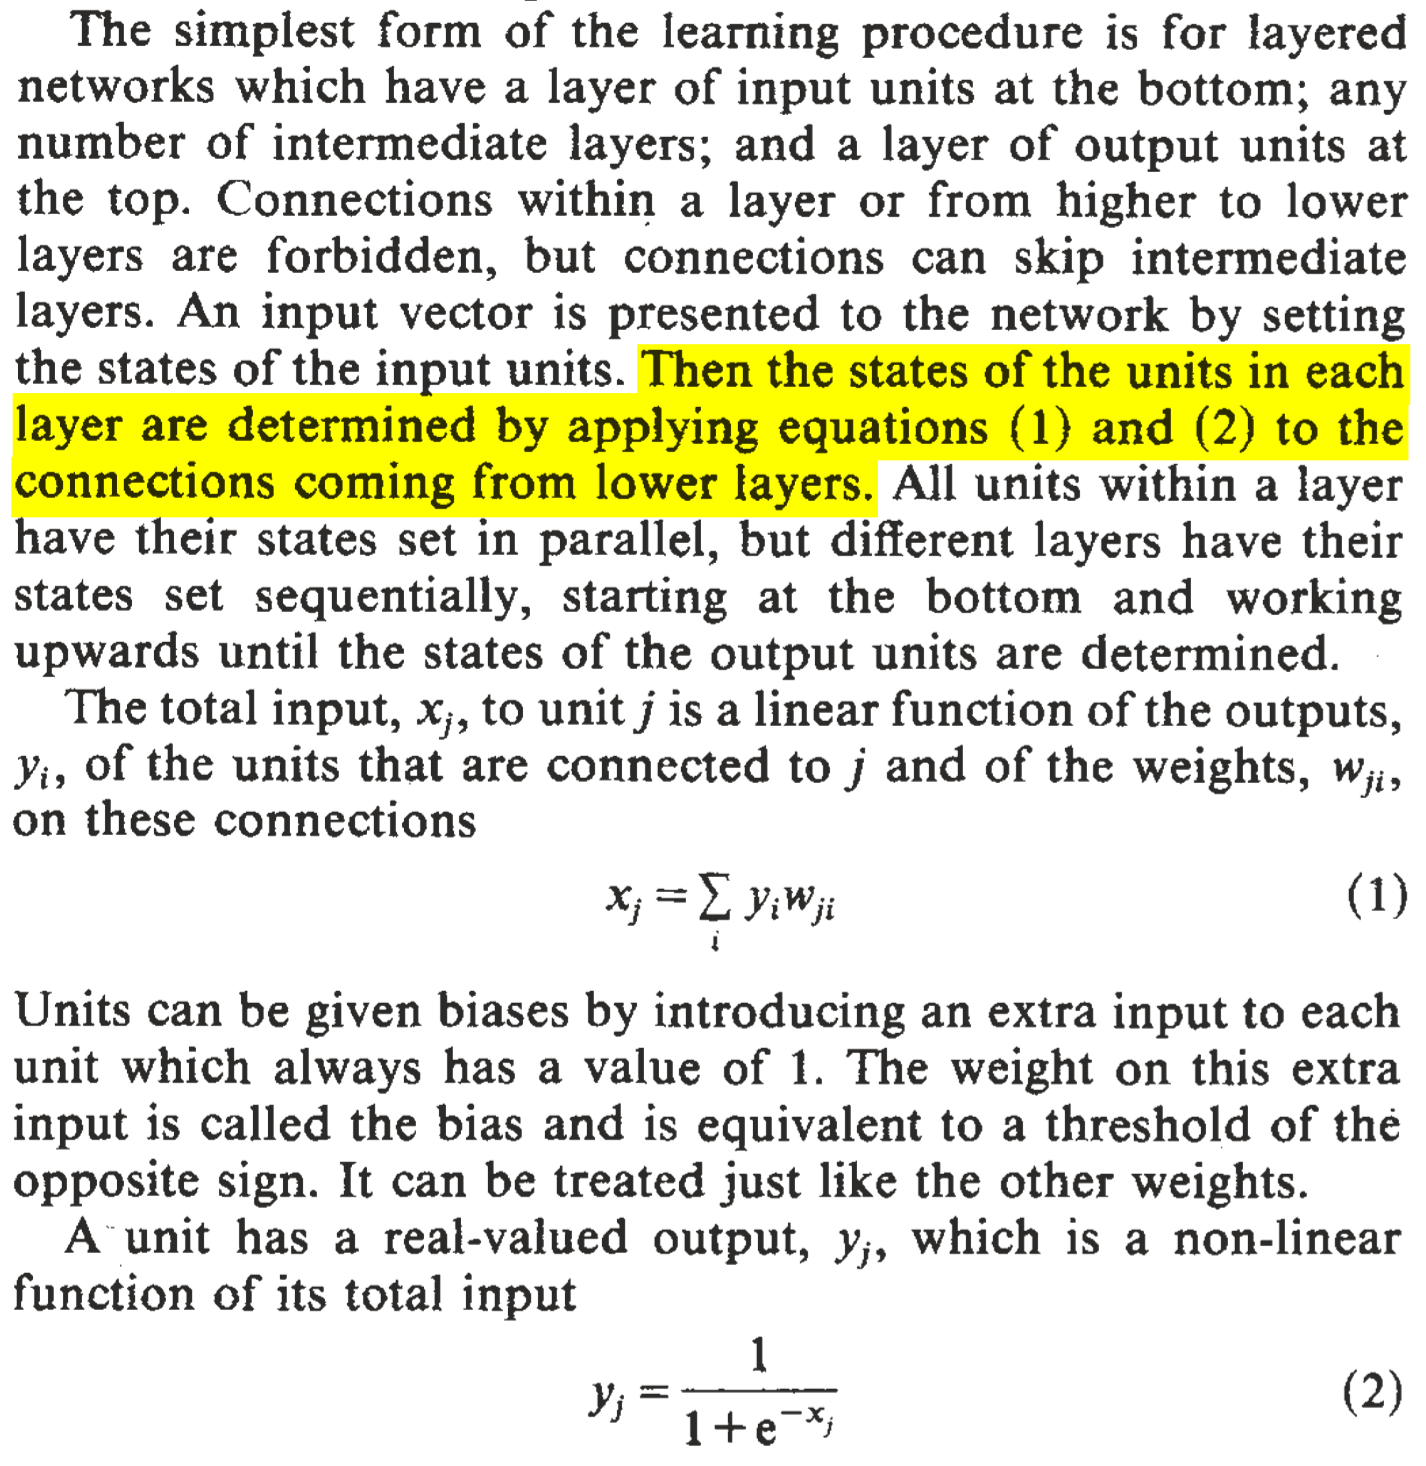

也就是我们现在说的线性函数+激活函数的架构了：

$$
y = (a_2 \circ h_2 \circ a_1 \circ h_1) (x)
$$

其中$a_1,a_2$是激活函数，$h1,h2$是隐藏层的线性函数

In [4]:
class MLP(nn.Module):
    """
    Multilayer Perceptron.
    
    Rumelhart, D. E., Hinton, G. E., & Williams, R. J. (1986). Learning representations by back-propagating errors. nature, 323(6088), 533-536.
    """

    def __init__(self, input_size, hidden_size, output_size=1):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.sigmoid(self.hidden(x))
        x = torch.sigmoid(self.output(x))
        return x

In [5]:
# training data
x1 = torch.randint(0, 2, (10000,))
x2 = torch.randint(0, 2, (10000,))
# input
X = torch.stack((x1, x2), dim=1)
# labels
Y = x1.__xor__(x2)
X.shape, Y.shape

(torch.Size([10000, 2]), torch.Size([10000]))

In [6]:
mlp = MLP(2, 2, 1)
loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)
dl = DataLoader(list(zip(X, Y)), batch_size=64, shuffle=True)
log = []
for epoch in range(30):
    total_loss = 0
    for i, (x, y) in enumerate(dl):
        x = x.float()
        y = y.float()
        pred = mlp(x)
        loss = loss_func(pred, y.view(-1, 1))
        mlp.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    log.append(total_loss / len(dl))

经过反向传播训练，我们的MLP已经可以完美复现XOR函数了

In [7]:
mlp(torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]]).float()).round()

tensor([[1.],
        [1.],
        [1.],
        [0.]], grad_fn=<RoundBackward0>)

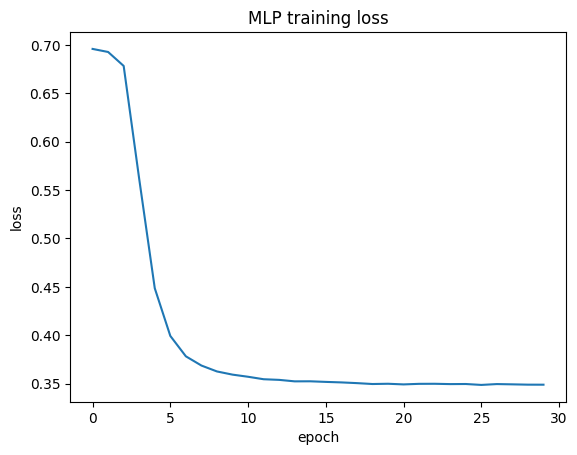

In [8]:
plt.plot(log)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('MLP training loss')
plt.show()

## 循环神经网络

循环神经网络（Recurrent neural network, RNN）也是在1986年提出的，他和MLP的主要区别在于：前者是一种**前馈神经网络**（Feedforward neural network, FFNN或者FNN），网络中不存在反馈（Feedback）和回环（Recurrent
）。通俗来说就是$y=f(x)$的计算过程中信息只会向前传递。

而RNN是为了序列数据而生的，它的设计理念很简单：建模序列数据之前的（一阶或者更高阶）相关性。

隐藏层的计算从：
$$
h = \sigma (Wx+b)
$$
变为（Elman network）
$$
h_t = \sigma (Wx_t+b+U{\color{red}h_{t-1}}+c)
$$

当然也有其他设计（Jordan network），引入一个额外中间变量$s_t$（state）：
$$
\begin{aligned}
&h_t = \sigma (W_1x_t+b_1+U_1s_{t}+c_1)\\
&s_t = \sigma (W_2s_{t-1}+b_2+W_3y_{t-1}+b_3)
\end{aligned}
$$

最终都输出：
$$
y_t = \sigma(W_y h_t + b_y)
$$

### 朴素实现

In [9]:
class ElmanRNN(nn.Module):
    """
    Elman RNN.

    Elman, J. L. (1990). Finding structure in time. Cognitive science, 14(2), 179-211.
    """

    def __init__(self, input_size, hidden_size, output_size=1):
        super(ElmanRNN, self).__init__()
        self.linear_x = nn.Linear(input_size, hidden_size)
        self.linear_h = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state=None):
        if hidden_state is None:
            # 初始化隐藏状态为零
            hidden_state = torch.zeros(x.size(0), self.linear_h.out_features)
        hidden_state = torch.tanh(self.linear_x(x) + self.linear_h(hidden_state))
        return torch.sigmoid(self.output(hidden_state)), hidden_state

In [10]:
rnn = ElmanRNN(3, 2, 1)

x = torch.randn(2, 3)
rnn(x)

(tensor([[0.4261],
         [0.4165]], grad_fn=<SigmoidBackward0>),
 tensor([[-0.0777, -0.6300],
         [ 0.1332, -0.6234]], grad_fn=<TanhBackward0>))

### torch.nn.RNNCell

当然，RNN层在`torch.nn`中已经有了实现
```python
hidden_state = torch.tanh(self.linear_x(x) + self.linear_h(hidden_state))
```
可以替换为：
```python
hidden_state = nn.RNNCell(3,2)(x, hidden_state)
```

In [11]:
rnn_cell = nn.RNNCell(3, 2)

In [12]:
# 由于浮点精度误差的存在，我们这里不使用torch.equal来判断两个tensor是否相等
# 而是使用torch.allclose来判断两个tensor是否在一定的精度范围内相等


torch.allclose(
    # torch封装的RNNCell
    rnn_cell(x, torch.ones(2, 2)),
    # 手动计算矩阵乘法和激活函数
    torch.tanh(
        x @ rnn_cell.weight_ih.T
        + torch.ones(2, 2) @ rnn_cell.weight_hh.T
        + rnn_cell.bias_hh
        + rnn_cell.bias_ih
    ),
)

True

可以看到我们手动计算的结果和torch的实现是一致的。

### torch.nn.RNN

上面的RNNCell只是单个时间步的计算。并且只有一层

一般情况RNN不会只有一层。所以我们通常需要构造多层的RNN。这时可以使用torch的封装：`torch.nn.RNN`

![](https://d2l.ai/_images/deep-rnn.svg)

In [13]:
input_size, hidden_size, num_layers = 3, 5, 2
rnn = nn.RNN(input_size, hidden_size, num_layers)
params = dict(rnn.named_parameters())
x = torch.randn(2, 4, 3)

我们可以打印出多层RNN的所有参数，可以清晰地看到所有：

In [14]:
for name, param in rnn.named_parameters():
    print(name, param.shape, sep=', ')

weight_ih_l0, torch.Size([5, 3])
weight_hh_l0, torch.Size([5, 5])
bias_ih_l0, torch.Size([5])
bias_hh_l0, torch.Size([5])
weight_ih_l1, torch.Size([5, 5])
weight_hh_l1, torch.Size([5, 5])
bias_ih_l1, torch.Size([5])
bias_hh_l1, torch.Size([5])


我们再用矩阵计算手撕一个RNN：

> 坑爹的是：torch官方文档里写的计算过程是错的😭，我特地提了一个[pr](https://github.com/pytorch/pytorch/pull/153620)

In [ ]:
def forward(x, hx=None, batch_first=False):
    if batch_first:
        x = x.transpose(0, 1)
    seq_len, batch_size, _ = x.size()
    if hx is None:
        hx = torch.zeros(rnn.num_layers, batch_size, rnn.hidden_size)
    h_t_minus_1 = hx.clone()
    h_t = hx.clone()
    output = []
    for t in range(seq_len):
        for layer in range(rnn.num_layers):
            input_t = x[t] if layer == 0 else h_t[layer - 1]
            h_t[layer] = torch.tanh(
                input_t @ params[f"weight_ih_l{layer}"].T
                + h_t_minus_1[layer] @ params[f"weight_hh_l{layer}"].T
                + params[f"bias_hh_l{layer}"]
                + params[f"bias_ih_l{layer}"]
            )
        output.append(h_t[-1].clone())
        h_t_minus_1 = h_t.clone()
    output = torch.stack(output)
    if batch_first:
        output = output.transpose(0, 1)
    return output, h_t

In [16]:
official_imp = rnn(x)
my_imp = forward(x)

# 由于浮点精度误差的存在，我们这里不使用torch.equal来判断两个tensor是否相等
assert torch.allclose(official_imp[0], my_imp[0])
assert torch.allclose(official_imp[1], my_imp[1])

In [17]:
official_imp[0], my_imp[0]

(tensor([[[ 0.3049, -0.5716, -0.1198,  0.0731, -0.7069],
          [-0.1524, -0.3530, -0.3632,  0.1876, -0.4165],
          [ 0.2681, -0.5221, -0.1478,  0.0610, -0.6897],
          [-0.3714, -0.5818, -0.4034,  0.0892, -0.3401]],
 
         [[-0.1850, -0.4844, -0.5273, -0.2168, -0.5664],
          [ 0.0519, -0.5502, -0.4163,  0.0933, -0.5516],
          [-0.5236, -0.2480, -0.6486,  0.0394, -0.2152],
          [ 0.0564, -0.6485, -0.4370,  0.1223, -0.5530]]],
        grad_fn=<StackBackward0>),
 tensor([[[ 0.3049, -0.5716, -0.1198,  0.0731, -0.7069],
          [-0.1524, -0.3530, -0.3632,  0.1876, -0.4165],
          [ 0.2681, -0.5221, -0.1478,  0.0610, -0.6897],
          [-0.3714, -0.5818, -0.4034,  0.0892, -0.3401]],
 
         [[-0.1850, -0.4844, -0.5273, -0.2168, -0.5664],
          [ 0.0519, -0.5502, -0.4163,  0.0934, -0.5516],
          [-0.5236, -0.2480, -0.6486,  0.0394, -0.2152],
          [ 0.0564, -0.6485, -0.4370,  0.1223, -0.5530]]],
        grad_fn=<StackBackward0>))

可以看到，我们手动计算的结果和torch封装的结果完全一致！

## 卷积神经网络

卷积神经网络（convolutional neural network, CNN）的思想最早1979年就被日本学者[福島邦彦](https://en.wikipedia.org/wiki/Kunihiko_Fukushima)提出了。后来LeCun在1988年提出了LeNet，就基本是现代CNN的形状了。

CNN是为了图像数据而生，它和MLP最大的区别在于前者是部分连接的网络，而后者是全连接神经网络（Fully Convolutional Neural Network, FCNN）。这一区别来自CNN最核心的算子：**卷积**。

在卷积操作下，神经网络层与层之间的连接不再是稠密的：后一层的任何一点都与前一层的所有点相关；而变地稀疏：后一层的点只与前一层的部分区域相关，这个区域大小就是感受野。

<img src="https://upload.wikimedia.org/wikipedia/commons/8/85/Convolution_arithmetic_-_Full_padding_no_strides_transposed.gif?20190413174624"> </img>

当然，卷积这个操作并非计算机领域的独创。数学上的卷积早已广泛应用于信号处理、图像处理、概率、微分方程等领域。

例如信号处理领域，卷积操作经常用来做滤波，例如高通滤波、低通滤波。类似的，在图像处理领域卷积操作也可以作为一种滤波器，例如sobel算子就是常用的边缘检测算子（提取高频信号）。

### LeNet

在torch中实现CNN也是比较简单的，有封装好的`torch.nn.Conv2d`可以用

In [18]:
class LeNet(nn.Module):
    """
    LeNet.

    LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), 2278-2324.
    """

    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = nn.functional.avg_pool2d(x, kernel_size=2, stride=2)
        x = torch.tanh(self.conv2(x))
        x = nn.functional.avg_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [19]:
lenet = LeNet()

In [20]:
from torchsummary import summary
_ = summary(lenet, (1, 28, 28), verbose=2)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 28, 28]           156
├─Conv2d: 1-2                            [-1, 16, 10, 10]          2,416
├─Linear: 1-3                            [-1, 120]                 48,120
├─Linear: 1-4                            [-1, 84]                  10,164
├─Linear: 1-5                            [-1, 10]                  850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
Total mult-adds (M): 0.42
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29


## 注意力机制

下面一段由GPT生成，我进行了文献的检索、核查，总体还是非常靠谱的

> 注意力机制（Attention Mechanism） 是一种模仿人类视觉注意力的机制，它使得模型在处理信息时能够有选择性地关注输入中的关键部分，而不是平均地处理所有信息。它最初用于图像处理领域：《[A model of saliency-based visual attention for rapid scene analysis](https://ieeexplore.ieee.org/abstract/document/730558/)》，后来在自然语言处理（NLP）中取得了巨大成功，尤其是在序列到序列（seq2seq）模型中，比如机器翻译。
>
> 1. 早期背景：seq2seq 模型存在问题
>    - 论文：《[Sequence to Sequence Learning with Neural Networks](https://research.google/pubs/sequence-to-sequence-learning-with-neural-networks/)》
>    - 在 2014 年，Google 提出的Encoder-Decoder 架构（seq2seq模型）在机器翻译中表现优越。
>    - 问题：将整个输入序列压缩成一个固定向量，会丢失大量信息，尤其是长句子。
> 
> 2. 2014 - Bahdanau et al.（Additive Attention）
>    - 论文：《[Neural Machine Translation by Jointly Learning to Align and Translate](https://peerj.com/articles/cs-2607/code.zip)》
>    - 特点：引入注意力机制解决 seq2seq 编码瓶颈，通过对输入每个时间步计算一个相关性打分。
>    - 方法：使用一个前馈神经网络计算注意力得分（加性注意力）。
> 
> 3. 2015 - Luong el al.（Multiplicative Attention）
>    - 论文：《[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025)》
>    - 特点：引入乘性注意力（dot-product 和 scaled dot-product），更计算高效。
> 
> 4. 2017 - Transformer
>    - 论文：《[Attention is All You Need](https://proceedings.neurips.cc/paper/2017/hash/3f5ee243547dee91fbd053c1c4a845aa-Abstract.html)》
>    - 创新：完全抛弃 RNN，全靠注意力机制（Self-Attention），并提出了多头注意力（Multi-Head Attention）。
>    - 特点：并行处理序列，高效捕捉全局依赖，开启了现代大型语言模型的时代（如 BERT、GPT）。
> 
> 5. 后续发展
>    - BERT（2018）：双向 Transformer 编码器，预训练语言理解。
>    - GPT 系列（2018）：基于 Transformer 解码器的生成式预训练模型。
>    - 视觉注意力（ViT, DETR 等）：将注意力机制应用于图像处理。
>    - Sparse Attention / Longformer / Performer：改进标准注意力在长序列上的效率问题。

本节的内容在[Sequence to Sequence (seq2seq) and Attention](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html)这个博客讲的很好，图示也绝美。请务必去看看！

### Attention

Wiki上有一个动图，直观展示了Attention的出发点：

![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Seq2seq_with_RNN_and_attention_mechanism.gif/500px-Seq2seq_with_RNN_and_attention_mechanism.gif)

我们无非是希望在Decoder中，尽量把**注意力**放在那些**更加相关**的变量上。

具体来说，在seq2seq模型中，模型由两个RNN构成:Encoder和Decoder。

Encoder把原始序列编码为数值向量：
$$
\vec H = (h_1,h_2,\cdots, h_n) = \mathrm{Enc}(\vec x)
$$
而后在Decoder的过程中，对于每一个$s_t$都计算注意力$\vec a$
$$
\vec a = (a(s_t, h_1),a(s_t, h_2),\cdots, a(s_t, h_n))
$$
其中$a$是某种计算，例如二次型($s^TWh$)、全连接神经网络($v^T(As+Bh+c)$)等（也就是我们最开始介绍的加性注意力和乘性注意力机制）。

接下来把softmax归一化的注意力引入到下一个状态的计算中：
$$
s_{t+1} = f(s_t, y_{t-1}, {\color{red} c_t})
$$
其中$c_t$称为context vector：
$$
c_t = \mathrm{softmax}(\vec a) \cdot \vec H
$$
最后得到最终结果：
$$
y = \mathrm{Dec}(\vec s) = \mathrm{Dec}(s_1,s_2,\cdots,s_t)
$$

上述计算过程可以看下图：
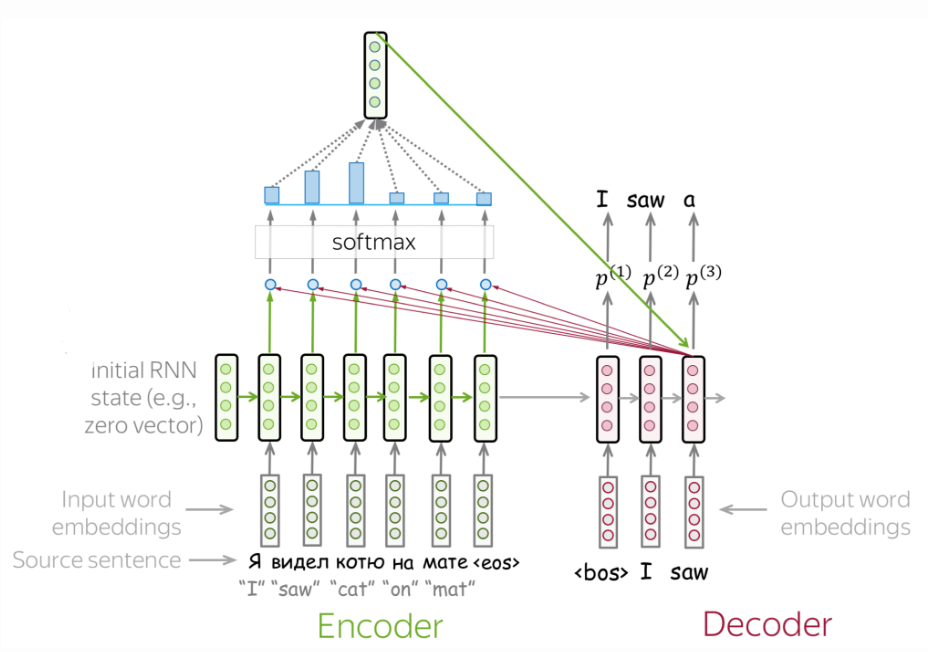

### Self-Attention
2017年，Transformer横空出世。注意力机制这么有用那我还要RNN干什么？于是他们打着Attention is all your need的旗号发布了Transformer。

想一下也不难理解，RNN的功能完全可以由Self-Attention代替。

一个典型的Encoder-Decoder RNN的计算过程是这样的：

$$
\vec x \to \vec h \to \vec s \to \vec y
$$

这里面RNN最重要的设计就是考虑滞后相关性：
$$
h_t = f(x_t, h_{t-1})
$$

如果使用自注意力机制，相当于$h_t$直接建模了全局相关性，是一种自回归：

$$
\vec h = \mathrm{SelfAttention}(\vec h)
$$

In [23]:
# 最简单的Transformer模型：
## 嵌入维度是26，头数是2，编码器和解码器各2层，前馈网络维度128，dropout 0.1
t = nn.Transformer(
    d_model=26,
    nhead=2,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
)
# (seq_len, batch_size, d_model)
src, tgt = torch.randn(10, 1, 26), torch.randn(10, 1, 26)
output = t(src, tgt)
output.shape

torch.Size([10, 1, 26])

如此简单的Transformer参数也是一堆：

In [24]:
for name,p in t.named_parameters():
    print(name, p.shape, sep=', ')

encoder.layers.0.self_attn.in_proj_weight, torch.Size([78, 26])
encoder.layers.0.self_attn.in_proj_bias, torch.Size([78])
encoder.layers.0.self_attn.out_proj.weight, torch.Size([26, 26])
encoder.layers.0.self_attn.out_proj.bias, torch.Size([26])
encoder.layers.0.linear1.weight, torch.Size([128, 26])
encoder.layers.0.linear1.bias, torch.Size([128])
encoder.layers.0.linear2.weight, torch.Size([26, 128])
encoder.layers.0.linear2.bias, torch.Size([26])
encoder.layers.0.norm1.weight, torch.Size([26])
encoder.layers.0.norm1.bias, torch.Size([26])
encoder.layers.0.norm2.weight, torch.Size([26])
encoder.layers.0.norm2.bias, torch.Size([26])
encoder.layers.1.self_attn.in_proj_weight, torch.Size([78, 26])
encoder.layers.1.self_attn.in_proj_bias, torch.Size([78])
encoder.layers.1.self_attn.out_proj.weight, torch.Size([26, 26])
encoder.layers.1.self_attn.out_proj.bias, torch.Size([26])
encoder.layers.1.linear1.weight, torch.Size([128, 26])
encoder.layers.1.linear1.bias, torch.Size([128])
encoder.l

In [27]:
sum(p.numel() for p in t.parameters())

44712

居然有四万多个参数。恐怖如斯。


接下来我们依然是用这些参数复现Transformer的计算过程：